In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from src.utils.visualization_utils import plot_points_as_histogramm

# Simulation of NFL Season 2010

As an example we simulate the NFL season 2010 with the schedule of that season

### Load schedule

Here we have the 2015 schedule of the NFL season containing all games that were played.
We want to simulate each game and assign a winner or a tie.

In [2]:
nfl_schedule_2010 = pd.read_csv("data/prepared_data/schedules/NFL/2010.csv")
nfl_observed = pd.read_parquet("data/prepared_data/NFL_data.parquet")
nfl_observed_2010 = nfl_observed[nfl_observed["Year"] == 2010]
nfl_schedule_2010.head()

,Home,Away
0,BUF,MIA
1,CHI,DET
2,HOU,IND
3,JAX,DEN
4,KC,LAC


### Assign a winner to each game

In this case the probabilities for winning, losing and a tie are [0.5, 0.5, 0.0]

In [3]:
nfl_schedule_2010["Winner"] = np.random.choice(
    ["Home", "Away", "Tie"], size=len(nfl_schedule_2010), p=[0.5, 0.5, 0.0]
)
nfl_schedule_2010["Outcome"] = nfl_schedule_2010.apply(
    lambda x: x["Home"]
    if x["Winner"] == "Home"
    else (x["Away"] if x["Winner"] == "Away" else "Tie"),
    axis=1,
)
nfl_schedule_2010.head()

,Home,Away,Winner,Outcome
0,BUF,MIA,Home,BUF
1,CHI,DET,Away,DET
2,HOU,IND,Home,HOU
3,JAX,DEN,Away,DEN
4,KC,LAC,Away,LAC


In [4]:
# Count the number of wins per team
win_counter = Counter(nfl_schedule_2010["Outcome"])

# As ties are unlikely to happen, it is possible that no ties occurred in the simulation
if "Tie" in win_counter:
    print("Tie")
    win_counter.pop("Tie")

# count the number of ties per team
tie_df = nfl_schedule_2010[nfl_schedule_2010["Outcome"] == "Tie"]
tie_list = list(tie_df["Home"].values) + list(tie_df["Away"].values)
tie_counter = Counter(tie_list)

# count the number of losses per team by subtracting the number of wins and ties from the number of games played for each team
loss_counter = (
    Counter(nfl_schedule_2010["Home"].values)
    + Counter(nfl_schedule_2010["Away"].values)
    - win_counter
    - tie_counter
)

### Visualize simulation results

To get the final table we need to calculate the overall points

$$ Points = Wins + 0.5*Ties $$

In [5]:
simulated_results_2010 = pd.DataFrame(
    [win_counter, loss_counter, tie_counter], index=["Wins", "Loses", "Ties"]
).T
# Replace NaN with 0 to avoid errors
simulated_results_2010.replace(np.nan, 0, inplace=True)
simulated_results_2010["Points"] = (
    simulated_results_2010["Wins"] + 0.5 * simulated_results_2010["Ties"]
)

#### Final table of simulated results

In [6]:
points = simulated_results_2010["Points"].values
simulated_results_2010.sort_values(by="Points", ascending=False)

,Wins,Loses,Ties,Points
JAX,11.0,5.0,0.0,11.0
DAL,11.0,5.0,0.0,11.0
DEN,10.0,6.0,0.0,10.0
MIA,10.0,6.0,0.0,10.0
CLE,10.0,6.0,0.0,10.0
SEA,9.0,7.0,0.0,9.0
LAC,9.0,7.0,0.0,9.0
NO,9.0,7.0,0.0,9.0
BAL,9.0,7.0,0.0,9.0
PHI,9.0,7.0,0.0,9.0


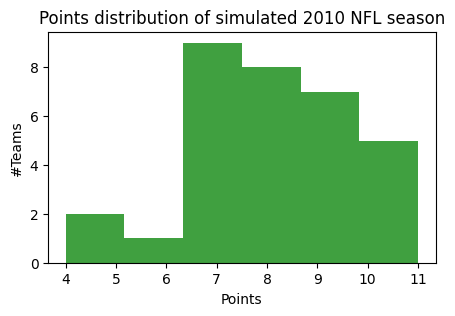

In [7]:
plot_points_as_histogramm(
    points,
    "Points distribution of simulated 2010 NFL season",
    stepsize=2,
    figsize=(5, 3),
)

### Calculate variance of the points

We calculate the sample variance of the final results (points). In order to make that value comparable across sports we min max scale the point vector first so the number of points per win and tie a team gets is irrelevant.

In [8]:
points_scaled = MinMaxScaler().fit_transform(points.reshape(-1, 1))
variance = np.var(points_scaled)
print(f"Variance: {variance}")

Variance: 0.05229591836734692


### Simulate results for 1000 seasons

In [9]:
from src.simulation.simulation_utils import simulate_league

sim_1000 = [
    simulate_league(
        nfl_schedule_2010,
        probabilities_win_loss_tie=[0.4999, 0.4999, 0.0002],
        points_for_win_loss_tie=[1, 0, 0.5],
        return_table=False,
        min_max_scaling=False,
    )
    for i in range(1000)
]

#### Plot some simulations

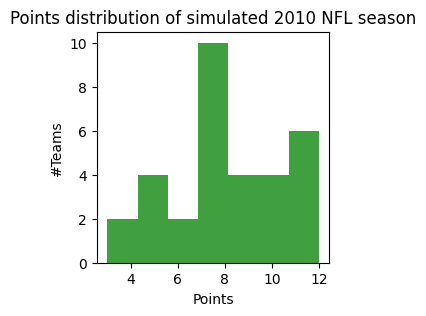

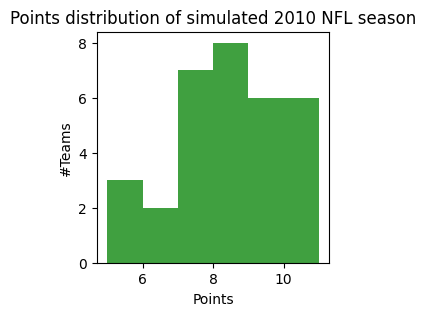

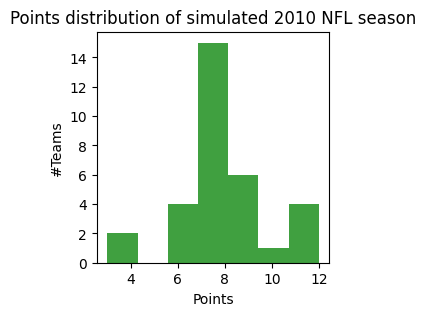

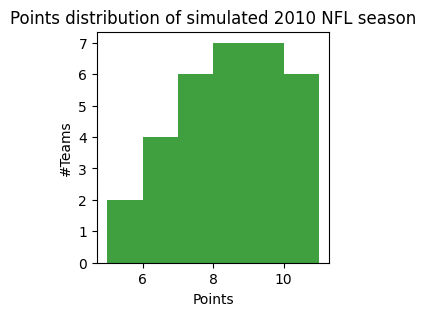

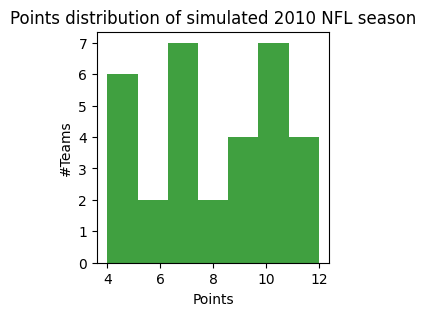

In [10]:
for sim in sim_1000[:5]:
    plot_points_as_histogramm(
        sim,
        "Points distribution of simulated 2010 NFL season",
        stepsize=2,
        figsize=(3, 3),
    )

#### Calculate the average variance over the simulated season

In [11]:
sim_1000_scaled = [MinMaxScaler().fit_transform(sim.reshape(-1, 1)) for sim in sim_1000]
mean_var = np.mean([np.var(sim) for sim in sim_1000_scaled])

print(f"Mean variance: {mean_var}")

Mean variance: 0.059645150605632025


In [12]:
from src.simulation.simulation_utils import (
    simulate_league_multiple_times,
    calculate_variance_of_simulated_leagues,
)

In [13]:
sims_1000 = simulate_league_multiple_times(
    nfl_schedule_2010,
    probabilities_win_loss_tie=[0.4999, 0.4999, 0.0002],
    points_for_win_loss_tie=[1, 0, 0.5],
    return_table=False,
    min_max_scaling=True,
    n=1000,
)

In [14]:
calculate_variance_of_simulated_leagues(sims_1000)

0.06077936887590068

### Visualize observed data

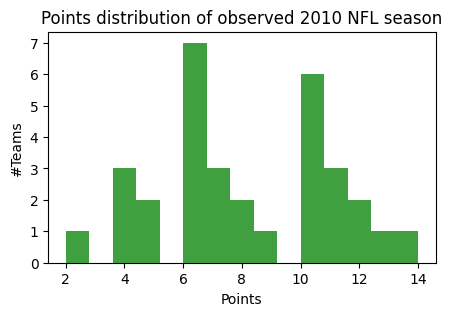

In [15]:
plot_points_as_histogramm(
    nfl_observed_2010["Wins"].values[0],
    "Points distribution of observed 2010 NFL season",
    stepsize=1,
    figsize=(5, 3),
)

## Create plots for the paper

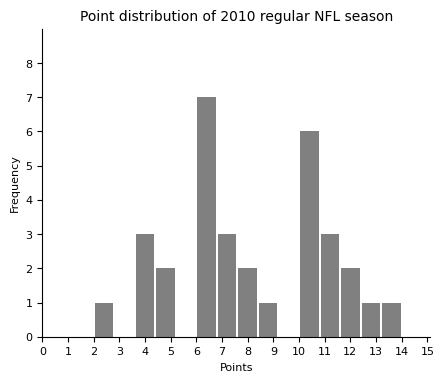

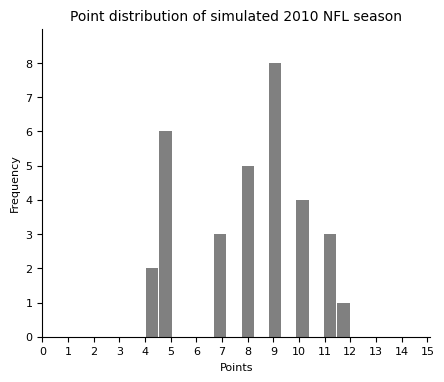

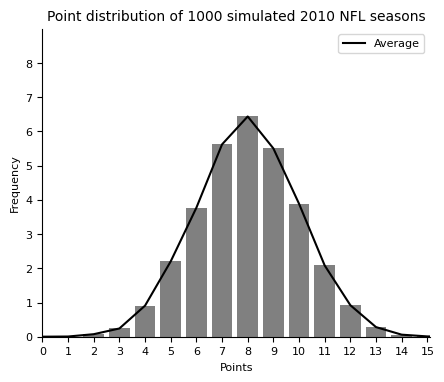

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# count the occurence of each point value
sims = np.array(sim_1000).flatten().astype(int)
counts = dict(Counter(sims))
counts = sorted(counts.items(), key=lambda x: x[0])
x = [x[0] for x in counts]
counts = [x[1] / len(sim_1000) for x in counts]


def plot_hist(data, title, type="hist"):
    # create subplot
    fig, ax = plt.subplots(1, 1, figsize=(5, 4))

    # plot histogram on fig
    if type == "hist":
        ax.hist(
            data,
            15,
            rwidth=0.9,
            color="gray",
        )
    elif type == "bar":
        ax.bar(
            data[0],
            data[1],
            color="gray",
        )
        ax.plot(
            data[0],
            data[1],
            color="black",
            label="Average",
        )
        ax.legend(loc="upper right", fontsize=8)
    # set x-axis limits
    ax.set_xlim(0, 15.1)
    ax.set_ylim(0, 9)
    ax.set_xticks(np.arange(0, 15.1, 1))
    ax.set_yticks(np.arange(0, 9, 1))
    ax.tick_params(axis="both", which="major", labelsize=8)
    right_side = ax.spines["right"]
    right_side.set_visible(False)
    top_side = ax.spines["top"]
    top_side.set_visible(False)
    # set title
    ax.set_title(title, fontsize=10)
    ax.set_xlabel("Points", fontsize=8)
    ax.set_ylabel("Frequency", fontsize=8)


plot_hist(
    nfl_observed_2010["Wins"].values[0], "Point distribution of 2010 regular NFL season"
)
plot_hist(sim_1000[10], "Point distribution of simulated 2010 NFL season")
plot_hist(
    (x, counts), "Point distribution of 1000 simulated 2010 NFL seasons", type="bar"
)

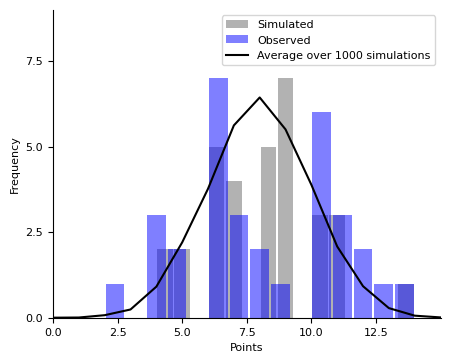

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.hist(
    sim_1000[9],
    15,
    rwidth=0.9,
    color="gray",
    alpha=0.6,
    label="Simulated",
)
ax.hist(
    nfl_observed_2010["Wins"].values[0],
    15,
    rwidth=0.9,
    color="blue",
    alpha=0.5,
    label="Observed",
)
# ax.bar(
#     data[0],
#     data[1],
#     color="gray",
# )
ax.plot(
    x,
    counts,
    color="black",
    label="Average over 1000 simulations",
)
# set x-axis limits
ax.set_xlim(0, 15)
ax.set_ylim(0, 9)
ax.set_xticks(np.arange(0, 15, 2.5))
ax.set_yticks(np.arange(0, 9, 2.5))
ax.tick_params(axis="both", which="major", labelsize=8)
right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)
# set title
# ax.set_title(title, fontsize=10)
ax.set_xlabel("Points", fontsize=8)
ax.set_ylabel("Frequency", fontsize=8)
ax.legend(loc="upper right", fontsize=8)

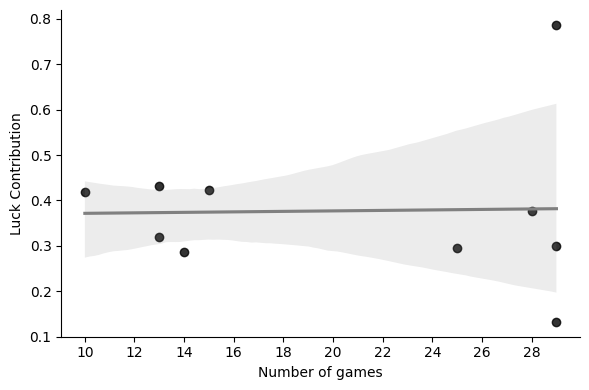

In [18]:
## Correlation plot
import seaborn as sns

df_result = pd.read_parquet("data/results/results_df.parquet")
df_result = df_result.iloc[:-2]
df_result["num_games"] = np.random.randint(10, 30, size=len(df_result))

# create scatterplot with regression line and confidence interval lines
p = sns.lmplot(
    df_result,
    y="Luck Contribution",
    x="num_games",
    line_kws={"color": "gray"},
    scatter_kws={"color": "black"},
    ci=95,
    height=4,
    aspect=1.5,
)
p.set(xlabel="Number of games", ylabel="Luck Contribution")
p.set(xticks=np.arange(10, 30, 2))